# Grid-Responsive Control of Indoor Air Temperature in Buildings With Differentiable Predictive Control

This notebook demonstrates how to use Differentiable Predictive Control (DPC) to control indoor air temperature in a single-zone building in response to grid signals.

---
## Motivation
Buildings today contribute to roughly 40 % of global energy use (approximately 64 PWh), of which a large portion is used for [heating, cooling, ventilation, and air-conditioning (HVAC)](https://en.wikipedia.org/wiki/Heating,_ventilation,_and_air_conditioning). Advanced grid-responsive control can help reduce peak demand and energy cost, mitigate greenhouse gas emissions, and support renewable integration. However, most commercial building automation systems still rely on simple rule-based strategies.  

Below is a simplified representation of a building control scheme responding to real-time price signals or demand response events:  
<img src="./figs/building_control.png" width="500">

---
## Differentiable Predictive Control (DPC)

[Differentiable Predictive Control](https://www.sciencedirect.com/science/article/pii/S0959152422000981) (DPC) is a model-based offline optimization algorithm that leverages differentiable system models to train constrained control policies.

**Key Features of DPC**:  
- **Differentiable system model**  
  We represent the building as a discrete-time state-space model  
  $$x_{k+1} = A\,x_k + B\,u_k + E\,d_k,\quad y_k = C\,x_k,$$  
  and exploit differentiability of each step to backpropagate through the closed-loop rollout.  
- **Constrained Neural Policy**  
  Learns a mapping  
  $$u_k = \pi_\theta\bigl(x_k,\;y_{\min},\;y_{\max},\;P_k\bigr)$$  
  that minimizes energy cost under price forecasts and enforces  
  $$y_{\min}\le y_k\le y_{\max},\quad u_{\min}\le u_k\le u_{\max}.$$  
- **Optimization Problem**  
  $$\begin{aligned}
  &\min_\theta\;\sum_{k=1}^{N-1} q_p\|u_k\|_{P_k}^2 + q_t||\max(0,y_k - y_{\max},y_{\min}-y_k)||_2^2\\
  &\text{subject to dynamics and bound constraints as above,}
  \end{aligned}$$  
  where $P_k$ is the time-varying price penalty and $q_p,q_t\in\mathcal{R}$ the gains which balance the tradeoff of energy/price minimization and temperature tracking. 
- **Schematics of the DPC method** [[1]](https://www.sciencedirect.com/science/article/pii/S0959152422000981):  

<p align="center">
  <img src="https://ars.els-cdn.com/content/image/1-s2.0-S0959152422000981-gr4_lrg.jpg" width="500">  
</p>

---
## Grid Response

[Grid Responsive Building Control](https://www.sciencedirect.com/science/article/pii/S0360544220327055?casa_token=QfpJZGrcwBEAAAAA:VwwPqJrRcl8wE14TyLvH62YJhaVYI8qVNAWzossdgmRxpEg9qm876iiWibkQKrjihKZBb17-ZA#fig4) is a broad collection of strategies, technologies, and methods that allow buildings to modulate their energy usage in response to signals from the grid. While many varieties of grid signals exist, the most common are variable pricing schemes, where utility providers create a rate schedule designed to incentivize energy load shifting [2]. Without onsite energy storage, one of the simplest methods for grid response is load shifting, demonstrated in the figure below. 

<img src="./figs/load_shifting.png" width="500">

In this notebook we demonstrate how Neuromancer and DPC can be used to train a controller to learn load shifting autonomously for controlling a simple HVAC system. 

## References
[1] Drgoňa, Ján, et al. "Differentiable predictive control: Deep learning alternative to explicit model predictive control for unknown nonlinear systems." Journal of Process Control 116 (2022)

[2] Cappers, Peter, Charles Goldman, and David Kathan. "Demand response in US electricity markets: Empirical evidence." Energy 35.4 (2010)



## For Colab only:

In [1]:
# !pip install neuromancer

*Note: When running on Colab, one might encounter a pip dependency error with Lida 0.0.10. This can be ignored*

## Environment & Dependencies

In [1]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import requests

from torch.utils.data import DataLoader
from torch.optim import AdamW
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer.modules import blocks
from neuromancer.system import Node, System
from neuromancer.dataset import DictDataset
from neuromancer.problem import Problem
from neuromancer.trainer import Trainer
from neuromancer.loggers import LossLogger
from neuromancer.psl import systems

# Building System

In [2]:
"""
Create state‑space nodes for the building dynamics, observation, and disturbance.
"""
sys = systems['LinearSimpleSingleZone']()
    
A = torch.tensor(sys.A)
B = torch.tensor(sys.Beta)
C = torch.tensor(sys.C)
E = torch.tensor(sys.E)

# problem dimensions
nx = sys.nx           # number of states
nu = sys.nu           # number of control inputs
nd = sys.nD           # number of disturbances
nd_obs = sys.nD_obs   # number of observable disturbances
ny = sys.ny           # number of controlled outputs
nref = ny             # number of references

# control action bounds
umin = torch.tensor(sys.umin)
umax = torch.tensor(sys.umax)

def xnext(x, u, d):     # x_{k+1} = A x_k + B u_k + E d_k
    return x @ A.T + u @ B.T + d @ E.T
state_model = Node(xnext, ['x', 'u', 'd'], ['x'], name='SSM')

def ynext(x):           # y_k = C x_k
    return x @ C.T
obs_model = Node(ynext, ['x'], ['y'], name='y=Cx')

def dist_obs(d):        # measurable subset of disturbance
    return d[:, sys.d_idx]
dist_model = Node(dist_obs, ['d'], ['d_obs'], name='dist_obs')


In [3]:
nsteps = 25
nsamples = 2000
batch_size = 2000
horizon = 48 # 48 time steps at 5 minute intervals = 4 hours of lookahead
ymin = 18.0
ymax = 27.0

# Random Seed for reproducibility
rndSeed = 2345
np.random.seed(rndSeed)

## Load PG&E Pricing Data

The following cell downloads the file automatically from a version hosted on github and saves it locally

Alternatively, the data can be found at the following link, under FAQ, the question of "How Might Hourly Prices Vary?"

https://www.pge.com/en/account/rate-plans/hourly-flex-pricing.html#accordion-cf73526c80-item-e7816eba98

In [5]:
url="https://raw.githubusercontent.com/EladMichael/small_example_datasets/main/hourly-flex-prices-historical-sample.xlsx"
response = requests.get(url)

os.makedirs('data',exist_ok=True)
with open('data/hourly-prices.xlsx', 'wb') as f:
    f.write(response.content)

from pandas import read_excel
prices = read_excel('data/hourly-prices.xlsx',sheet_name='HFP_Prices',usecols=[10],skiprows=3).to_numpy().flatten()
prices = np.repeat(prices, 12).reshape((-1, 1)) # price is hourly, this makes it into 5 minute increments

In [10]:
def make_lookahead(arr: torch.Tensor, horizon: int) -> torch.Tensor:
    """Construct look‑ahead feature matrix.

    Parameters
    ----------
    arr : Tensor [B, T, D]
    horizon : int
        Number of future steps to stack.

    Returns
    -------
    Tensor [B, T‑horizon+1, D*horizon]
    """
    B, nsteps, D = arr.shape
    if horizon < 1:
        raise ValueError("horizon must be >= 1")

    lookahead_arr = torch.zeros((B, nsteps - horizon + 1, D * horizon))
    for b in range(B):
        for step in range(nsteps - horizon + 1):
            lookahead_arr[b, step, :] = arr[b, step:step + horizon, :].flatten()
    return lookahead_arr

### Useful lambda function to make lookahead a little smoother to write/read
lookahead = lambda x: make_lookahead(x,horizon)

def build_lookahead_dataloader(
    sys,
    prices: np.ndarray,
    nsteps: int,
    nsamples: int,
    batch_size: int,
    ymin: float,
    ymax: float,
    name: str,
    horizon: int,
):
    """Create a DataLoader of random rollouts with look‑ahead exogenous signals."""

    ymin_gen = torch.distributions.Uniform(ymin, 0.5*(ymin+ymax))
    ymax_gen = torch.distributions.Uniform(0.5*(ymin+ymax), ymax)

    batched_ymin = ymin_gen.sample((nsamples, 1, sys.ny)).repeat(1, nsteps+horizon, 1)
    batched_ymax = ymax_gen.sample((nsamples, 1, sys.ny)).repeat(1, nsteps+horizon, 1)
    ymin_lookahead = lookahead(batched_ymin)
    ymax_lookahead = lookahead(batched_ymax)

    # choose random starting indices that line up with the same 5‑minute slot
    p_idxs = [np.random.randint(0, prices.shape[0]-nsteps-horizon) for _ in range(nsamples)]
    const = 288*((sys._D.shape[0]-nsteps-horizon)//288)
    d_idxs = [idx % const for idx in p_idxs]

    batched_dist = torch.stack([
        torch.tensor(sys._D[idx:idx+nsteps+horizon], dtype=torch.float) for idx in d_idxs
    ])
    batched_dist[:, :, 0] -= 10.0   # make it colder, to ensure only heating is needed
    dist_lookahead = lookahead(batched_dist[:, :, sys.d_idx])

    batched_price = torch.stack([
        torch.tensor(prices[idx:idx+nsteps+horizon], dtype=torch.float) for idx in p_idxs
    ])
    price_lookahead = lookahead(batched_price)

    batched_x0 = torch.stack([torch.tensor(sys.get_x0(), dtype=torch.float).unsqueeze(0)
                              for _ in range(nsamples)])

    data = DictDataset(
        {
            "x": batched_x0,
            "ymin_lookahead": ymin_lookahead,
            "ymax_lookahead": ymax_lookahead,
            "d": batched_dist[:, :nsteps, :],
            "d_obs_lookahead": dist_lookahead,
            "price_lookahead": price_lookahead,
            "d_idx": torch.tensor(d_idxs).reshape(nsamples, 1, 1),
        },
        name=name,
    )

    return DataLoader(data, batch_size=batch_size, collate_fn=data.collate_fn, shuffle=True)

def print_data(data):
    for key in data:
        if hasattr(data[key], 'shape'):
            print(key, " : ", data[key].shape, " , ", data[key].dtype)
        else:
            print(key, " : ", data[key])

In [11]:
# ---- dataset ---------------------------------------------------------------
train_loader = build_lookahead_dataloader(sys, prices,
                                          nsteps,
                                          nsamples,
                                          batch_size,
                                          ymin, ymax,
                                          name='train',
                                          horizon=horizon)

dev_loader = build_lookahead_dataloader(sys, prices,
                                        nsteps,
                                        nsamples//5,
                                        batch_size,
                                        ymin, ymax,
                                        name='dev',
                                        horizon=horizon)

### We can examine one element of the data loaders, to see the lookahead tensors shape

In [12]:
print_data(next(iter(train_loader)))

x  :  torch.Size([2000, 1, 4])  ,  torch.float32
ymin_lookahead  :  torch.Size([2000, 26, 48])  ,  torch.float32
ymax_lookahead  :  torch.Size([2000, 26, 48])  ,  torch.float32
d  :  torch.Size([2000, 25, 3])  ,  torch.float32
d_obs_lookahead  :  torch.Size([2000, 26, 48])  ,  torch.float32
price_lookahead  :  torch.Size([2000, 26, 48])  ,  torch.float32
d_idx  :  torch.Size([2000, 1, 1])  ,  torch.int64
name  :  train


## Neural Network Control Policy

In [13]:
h_size = 32
n_layers = 2

no_forecast_inputs = ['y']
forecast_inputs = ['d_obs', 'ymin', 'ymax', 'price']
forecast_inputs = [var+'_lookahead' for var in forecast_inputs]
inputs = no_forecast_inputs+forecast_inputs

forecast_sizes = (horizon)*np.array([sys.nD_obs, sys.ny, sys.ny, 1])
no_forecast_sizes = [sys.ny]
input_size = sum(no_forecast_sizes) + sum(forecast_sizes)

In [15]:
"""
Fully‑connected neural network policy with element‑wise bounds.
"""
net = blocks.MLP_bounds(
    insize=input_size,
    outsize=sys.nu,
    hsizes=[h_size]*n_layers,
    nonlin=torch.nn.LeakyReLU,
    min=torch.tensor(sys.umin),
    max=torch.tensor(sys.umax),
)
policy = Node(net, inputs, ['u'], name='policy')

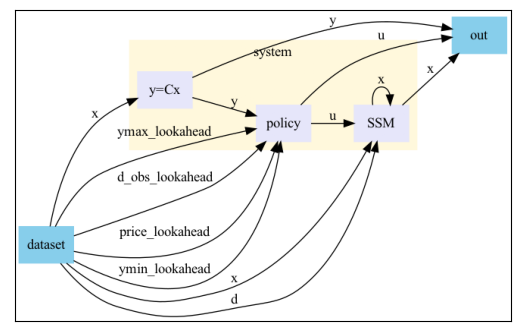

In [16]:
cl_system = System([obs_model, policy, state_model],
                   nsteps=nsteps,
                   name='cl_system')
cl_system.show()

## Loss Function

In [17]:
price_gain = 1.5
action_gain = 0
smooth_gain = 0
comfort_gain = 7.5e06

y_var = variable('y')
u_var = variable('u')
ymin_var = variable('ymin_lookahead')[:, :-1, 0:1]
ymax_var = variable('ymax_lookahead')[:, :-1, 0:1]
price_var = variable('price_lookahead')[:, :-1, 0:1]

In [18]:
"""
Composite loss:
  1. energy use weighted by real‑time price
  3. comfort constraints (soft)
"""

# price-weighted energy use
price_loss_var = price_gain * ((u_var * price_var) == torch.zeros_like(u_var)) ^ 2
action_loss = action_gain * (u_var == torch.zeros_like(u_var)) ^ 2
comfort_lower = comfort_gain * (y_var > ymin_var)
comfort_upper = comfort_gain * (y_var < ymax_var)

price_loss_var.name = 'price_loss'
action_loss.name = 'action_loss'
comfort_lower.name = 'y_min'
comfort_upper.name = 'y_max'

objectives = [price_loss_var, action_loss]
constraints = [comfort_lower, comfort_upper]

loss = PenaltyLoss(objectives, constraints)

## Differentiable Optimal Control Problem

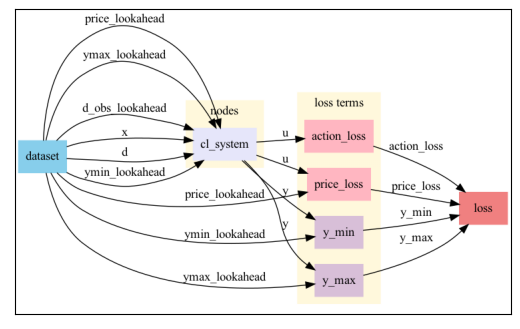

In [19]:
problem = Problem(nodes=[cl_system], loss=loss)
problem.show()

# Solve Problem

In [20]:
optimizer = AdamW(problem.parameters(), lr=1e-3)

logger = LossLogger(verbosity=1, stdout=['dev_loss', 'train_loss'])
#  Neuromancer trainer
trainer = Trainer(
    problem,
    train_loader,
    dev_loader,
    optimizer=optimizer,
    epochs=200,
    logger=logger,
    train_metric='train_loss',
    eval_metric='dev_loss',
    warmup=20,
    patience=50,
)

# Train control policy
# print_data(next(iter(train_loader)))
best_model = trainer.train()
# load best trained model
trainer.model.load_state_dict(best_model)

None
Number of parameters: 7297
epoch: 0	train_loss: 2718075.75000	dev_loss: 2822818.75000	eltime:  0.17766
epoch: 1	train_loss: 2876190.25000	dev_loss: 2606671.25000	eltime:  0.29655
epoch: 2	train_loss: 2734158.00000	dev_loss: 2261272.50000	eltime:  0.39901
epoch: 3	train_loss: 2549976.75000	dev_loss: 2196483.00000	eltime:  0.49356
epoch: 4	train_loss: 2580343.50000	dev_loss: 2190001.00000	eltime:  0.59409
epoch: 5	train_loss: 2560767.50000	dev_loss: 2179879.00000	eltime:  0.78179
epoch: 6	train_loss: 2508052.00000	dev_loss: 2228435.50000	eltime:  0.87905
epoch: 7	train_loss: 2497115.50000	dev_loss: 2239840.50000	eltime:  0.98263
epoch: 8	train_loss: 2488753.00000	dev_loss: 2182105.25000	eltime:  1.10816
epoch: 9	train_loss: 2454410.00000	dev_loss: 2163057.75000	eltime:  1.21294
epoch: 10	train_loss: 2464062.75000	dev_loss: 2158135.25000	eltime:  1.31582
epoch: 11	train_loss: 2455202.50000	dev_loss: 2170167.75000	eltime:  1.41968
epoch: 12	train_loss: 2425079.50000	dev_loss: 2237014.

<All keys matched successfully>

### Create test dataset, and test trained controller

In [21]:
nsteps_test = 2017

# generate disturbance signals
p_idx = np.random.randint(0, prices.shape[0]-nsteps_test-horizon)
d_idx = p_idx % (288*((sys._D.shape[0]-nsteps_test-horizon)//288))

dist = torch.tensor(
    sys._D[d_idx:d_idx+nsteps_test+horizon], dtype=torch.float).unsqueeze(0)

# make it colder!
dist[:, :, 0] -= 10

dist_lookahead = lookahead(dist[:, :, sys.d_idx])
price = torch.tensor(
    prices[p_idx:p_idx+nsteps_test+horizon], dtype=torch.float).unsqueeze(0)
price_lookahead = lookahead(price)

ymin_sig = ymin*torch.ones((1, nsteps_test+horizon, 1))
ymax_sig = ymax*torch.ones((1, nsteps_test+horizon, 1))

ymin_lookahead = lookahead(ymin_sig)
ymax_lookahead = lookahead(ymax_sig)

# initial data for closed loop simulation
x0 = torch.tensor(
    sys.get_x0(), dtype=torch.float).reshape(1, 1, sys.nx)

test_data = {'x': x0,
        'ymin_lookahead': ymin_lookahead,
        'ymax_lookahead': ymax_lookahead,
        'd': dist[:, :nsteps_test, :],
        'd_obs_lookahead': dist_lookahead,
        'price_lookahead': price_lookahead,
        'd_idx': torch.tensor(d_idx).reshape(1, 1, 1)}

In [22]:
cl_system.nsteps = nsteps_test

traj = cl_system(test_data)

# Uncomment to examine the shapes of the fields
# print_data(traj)

## Plot Results

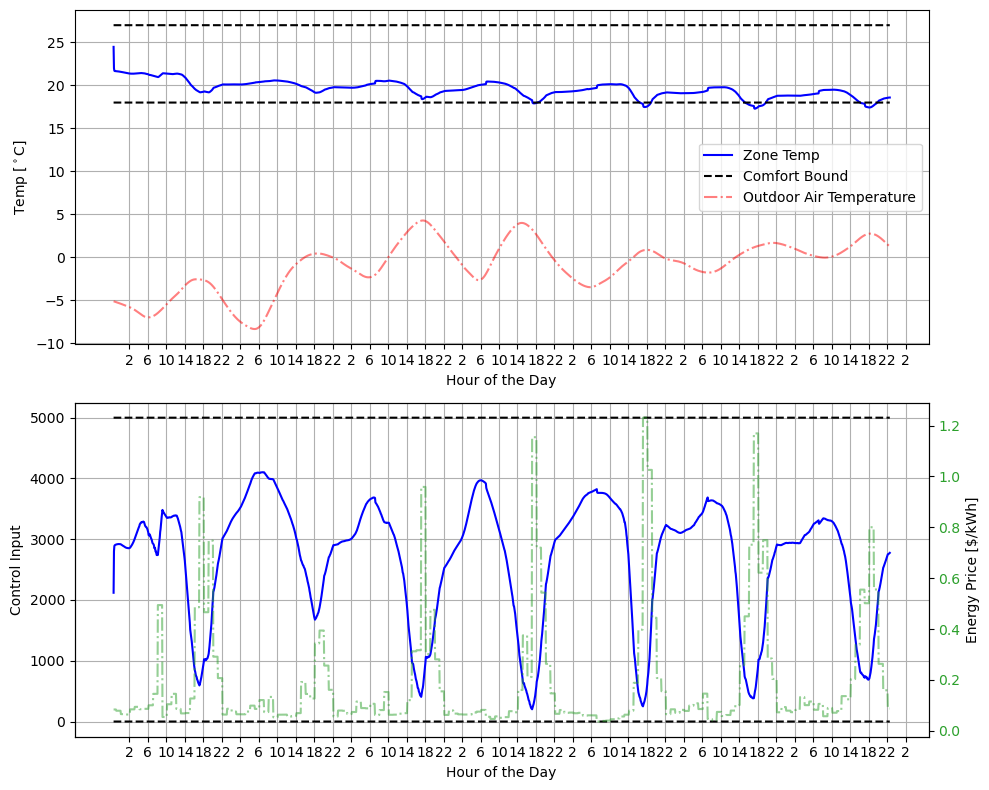

In [23]:
nZones = sys.ny
nsteps = traj['y'].shape[1]
t = np.arange(0, nsteps_test)

d_hour = 4

offset = traj['d_idx'].detach().numpy().flatten()[0] % 48

hour_ticks = np.arange(offset, nsteps+offset+1, d_hour*12)

hour_0 = (traj['d_idx']+offset)//12

hour_labels = np.arange(hour_0, hour_0+1+nsteps//12, d_hour) % 24

fig, axs = plt.subplots(nZones*2, figsize=(10, 8))

def get(traj, key, nsteps, zidx):
    return traj[key][:, :nsteps, zone].detach().numpy().flatten()

ymin = traj['ymin_lookahead'][:, :nsteps, 0:nZones].detach().numpy()
ymax = traj['ymax_lookahead'][:, :nsteps, 0:nZones].detach().numpy()
prices = traj['price_lookahead'][:,:nsteps, 0:1].detach().numpy().flatten()

for zone in range(nZones):
    axs[zone].plot(t, get(traj, 'y', nsteps, zone),
                   "-", color="blue", label="Zone Temp")
    axs[zone].plot(t, ymin[:, :, zone].flatten(), "--",
                   color="black", label="Comfort Bound")
    axs[zone].plot(t, ymax[:, :, zone].flatten(), "--", color="black")
    axs[zone].plot(t, get(traj, 'd', nsteps, 0), "-.",
                   color="red", alpha=0.5, label="Outdoor Air Temperature")
    axs[zone].grid()
    axs[zone].set_ylabel(r'Temp [$^\circ$C]')
    axs[zone].set_xticks(hour_ticks, hour_labels)
    axs[zone].set_xlabel("Hour of the Day")
    axs[zone].legend(loc='best')

    axs[zone+1].plot(t, get(traj, 'u', nsteps, zone), "-", color="blue")
    if sys.umax.size == 1:
        axs[zone+1].plot(t, [sys.umax]*nsteps, "--", color="black")
        axs[zone+1].plot(t, [sys.umin]*nsteps, "--", color="black")
    else:
        axs[zone+1].plot(t, [sys.umax[zone]]*nsteps, "--", color="black")
        axs[zone+1].plot(t, [sys.umin[zone]]*nsteps, "--", color="black")
    axs[zone+1].set_ylabel('Control Input')
    axs[zone+1].set_xticks(hour_ticks, hour_labels)
    axs[zone+1].set_xlabel("Hour of the Day")
    axs[zone+1].grid()

    color = 'tab:green'
    ax2 = axs[zone+1].twinx()
    ax2.set_ylabel('Energy Price [$/kWh]')
    ax2.plot(t, prices,
             "-.", color=color, alpha=0.5)
    ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()